Enter layout width (e.g. 100):  100
Enter layout height (e.g. 100):  100
Enter number of sensors (e.g. 10):  10
Enter minimum sensor radius (e.g. 5):  5
Enter maximum sensor radius (e.g. 20):  20
Enter fixed cost per sensor (e.g. 10):  10



--- Final Optimization Result ---
Best Fitness (F1/F2)   : 17.7265
Total Cost (F1)        : 259.97
Covered Points (F2)    : 9823
Runtime (seconds)      : 18.94


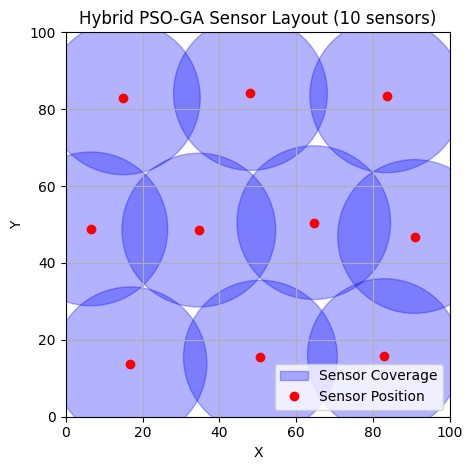

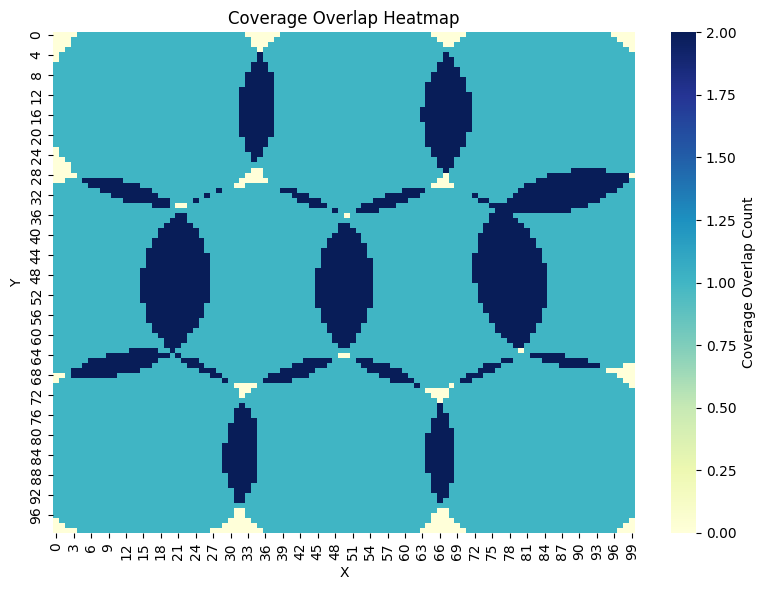

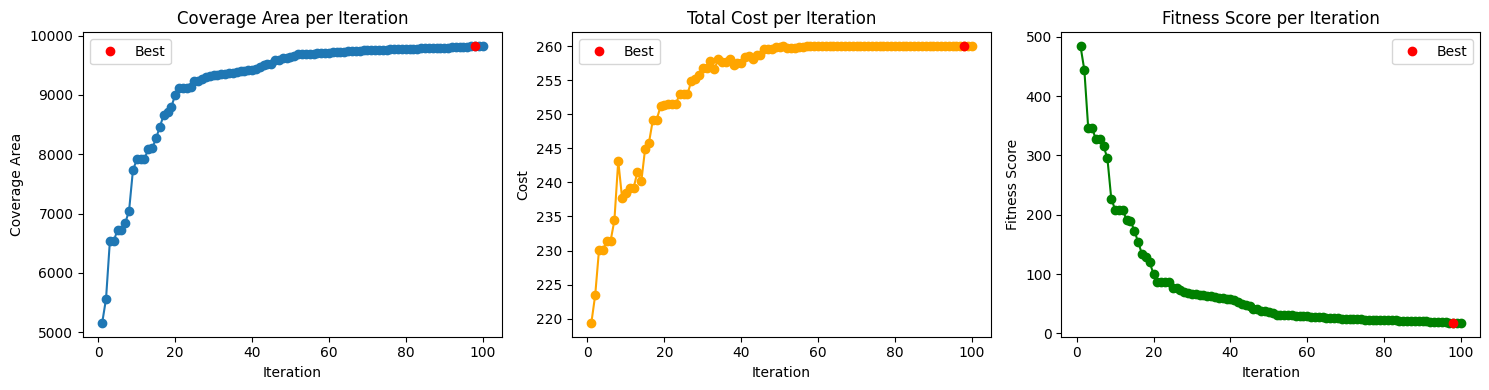


Sensor Placement Details:
 Sensor #     X     Y  Radius  Cost
        1 83.54 83.50   20.00 26.00
        2 16.78 13.79   19.97 25.97
        3 48.07 84.09   20.00 26.00
        4 64.55 50.49   19.99 25.99
        5 34.65 48.55   20.00 26.00
        6  6.55 48.87   20.00 26.00
        7 15.00 82.97   20.00 26.00
        8 90.78 46.88   20.00 26.00
        9 82.92 15.91   20.00 26.00
       10 50.66 15.50   20.00 26.00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

# ---------------- 1. Configuration with User Input ----------------
params = {
    "area_width": int(input("Enter layout width (e.g. 100): ")),
    "area_height": int(input("Enter layout height (e.g. 100): ")),
    "sensor_count": int(input("Enter number of sensors (e.g. 10): ")),
    "r_min": float(input("Enter minimum sensor radius (e.g. 5): ")),
    "r_max": float(input("Enter maximum sensor radius (e.g. 20): ")),
    "fixed_cost": float(input("Enter fixed cost per sensor (e.g. 10): ")),
    
    "cost_per_radius": 0.8,
    "min_coverage_per_point": 1,
    "grid_resolution": 1.0,
    "swarm_size": 30,
    "max_iter": 100,
    "ga_generations": 50,
    "mutation_rate": 0.2
}

# ---------------- 2. Grid Setup ----------------
x_coords = np.arange(0, params["area_width"], params["grid_resolution"])
y_coords = np.arange(0, params["area_height"], params["grid_resolution"])
xx, yy = np.meshgrid(x_coords, y_coords)
GRID = np.c_[xx.ravel(), yy.ravel()]
dim = params["sensor_count"] * 3
lb = np.tile([0, 0, params["r_min"]], params["sensor_count"])
ub = np.tile([params["area_width"], params["area_height"], params["r_max"]], params["sensor_count"])
EPS = 1e-6
PENALTY = 1000  # Adjusted to prevent extreme fitness scores

fitness_history = []
coverage_history = []
cost_history = []
position_history = []

# ---------------- 3. Fitness Function based on Equation (4) ----------------
def fitness(x):
    global last_heatmap
    coverage = np.zeros(len(GRID), dtype=int)
    cost = 0.0

    for i in range(params["sensor_count"]):
        x_s, y_s, r = x[i*3:i*3+3]
        dist = np.hypot(GRID[:, 0] - x_s, GRID[:, 1] - y_s)
        cover_mask = dist <= r
        coverage += cover_mask.astype(int)
        cost += params["fixed_cost"] + params["cost_per_radius"] * r

    uncovered = np.sum(coverage < params["min_coverage_per_point"])
    F1 = cost
    F2 = np.sum(coverage >= params["min_coverage_per_point"])
    last_heatmap = coverage
    if F2 == 0:
        return float("inf"), F1, F2
    penalty = PENALTY * (uncovered / len(GRID))
    return F1 / (F2 + EPS) + penalty, F1, F2

# ---------------- 4. PSO + GA ----------------
V_MAX_FACTOR = 0.2
W_INERTIA = 0.7
C1 = 1.5
C2 = 1.5

np.random.seed(42)
pos = np.random.uniform(lb, ub, (params["swarm_size"], dim))
vel = np.random.uniform(-1, 1, (params["swarm_size"], dim)) * (ub - lb) * V_MAX_FACTOR
pbest_pos = pos.copy()
pbest_val = np.full(params["swarm_size"], np.inf)
gbest_val = np.inf
gbest_pos = None

start_time = time.perf_counter()

for t in range(params["max_iter"]):
    for i in range(params["swarm_size"]):
        f, f1, f2 = fitness(pos[i])
        if f < pbest_val[i]:
            pbest_val[i] = f
            pbest_pos[i] = pos[i].copy()
        if f < gbest_val:
            gbest_val = f
            gbest_pos = pos[i].copy()
            best_cost = f1
            best_coverage = f2

    fitness_history.append(gbest_val)
    cost_history.append(best_cost)
    coverage_history.append(best_coverage)
    position_history.append(gbest_pos.copy())

    # --- GA Search
    for _ in range(params["ga_generations"]):
        children = []
        for _ in range(3):
            idx = np.random.choice(len(pbest_pos), 2, replace=False)
            p1, p2 = pbest_pos[idx[0]], pbest_pos[idx[1]]
            cross = np.where(np.random.rand(dim) < 0.5, p1, p2)
            if np.random.rand() < params["mutation_rate"]:
                mi = np.random.randint(0, dim)
                cross[mi] += np.random.normal(0, 0.1 * (ub[mi] - lb[mi]))
            cross = np.clip(cross, lb, ub)
            children.append(cross)
        for child in children:
            f, f1, f2 = fitness(child)
            if f < gbest_val:
                gbest_val = f
                gbest_pos = child.copy()
                best_cost = f1
                best_coverage = f2

    # --- PSO Update
    r1, r2 = np.random.rand(params["swarm_size"], dim), np.random.rand(params["swarm_size"], dim)
    vel = (W_INERTIA * vel +
           C1 * r1 * (pbest_pos - pos) +
           C2 * r2 * (gbest_pos - pos))
    vel = np.clip(vel, -V_MAX_FACTOR * (ub - lb), V_MAX_FACTOR * (ub - lb))
    pos = np.clip(pos + vel, lb, ub)

# ---------------- 5. Summary Output ----------------
runtime = time.perf_counter() - start_time
print("\n--- Final Optimization Result ---")
print(f"Best Fitness (F1/F2)   : {gbest_val:.4f}")
print(f"Total Cost (F1)        : {best_cost:.2f}")
print(f"Covered Points (F2)    : {best_coverage}")
print(f"Runtime (seconds)      : {runtime:.2f}")

# ---------------- 6. Layout Plot ----------------
fig, ax = plt.subplots()
ax.set_xlim(0, params["area_width"])
ax.set_ylim(0, params["area_height"])
ax.set_aspect('equal')
ax.set_title(f'Hybrid PSO-GA Sensor Layout ({params["sensor_count"]} sensors)')
for i in range(params["sensor_count"]):
    x, y, r = gbest_pos[i*3], gbest_pos[i*3+1], gbest_pos[i*3+2]
    ax.add_patch(plt.Circle((x, y), r, color='blue', alpha=0.3, label='Sensor Coverage' if i == 0 else ""))
    ax.plot(x, y, 'ro', label='Sensor Position' if i == 0 else "")
handles, labels = ax.get_legend_handles_labels()
ax.legend(dict(zip(labels, handles)).values(), dict(zip(labels, handles)).keys())
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

# ---------------- 7. Heatmap ----------------
heatmap = last_heatmap.reshape((len(y_coords), len(x_coords)))
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap, cmap='YlGnBu', cbar_kws={'label': 'Coverage Overlap Count'})
plt.title('Coverage Overlap Heatmap')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

# ---------------- 8. Convergence Plots ----------------
best_iter = np.argmin(fitness_history)
iterations = list(range(1, len(fitness_history) + 1))

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(iterations, coverage_history, 'o-')
plt.plot(iterations[best_iter], coverage_history[best_iter], 'ro', label='Best')
plt.title("Coverage Area per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Coverage Area")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(iterations, cost_history, 'o-', color='orange')
plt.plot(iterations[best_iter], cost_history[best_iter], 'ro', label='Best')
plt.title("Total Cost per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(iterations, fitness_history, 'o-', color='green')
plt.plot(iterations[best_iter], fitness_history[best_iter], 'ro', label='Best')
plt.title("Fitness Score per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Fitness Score")
plt.legend()

plt.tight_layout()
plt.show()

# ---------------- 9. Print Sensor Details ----------------
import pandas as pd

sensor_details = {
    "Sensor #": [],
    "X": [],
    "Y": [],
    "Radius": [],
    "Cost": []
}

for i in range(params["sensor_count"]):
    x = gbest_pos[i*3]
    y = gbest_pos[i*3 + 1]
    r = gbest_pos[i*3 + 2]
    cost = params["fixed_cost"] + params["cost_per_radius"] * r
    sensor_details["Sensor #"].append(i + 1)
    sensor_details["X"].append(round(x, 2))
    sensor_details["Y"].append(round(y, 2))
    sensor_details["Radius"].append(round(r, 2))
    sensor_details["Cost"].append(round(cost, 2))

df = pd.DataFrame(sensor_details)
print("\nSensor Placement Details:")
print(df.to_string(index=False))

